In [105]:
import gpflow
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

Data set

In [121]:
from numpy import genfromtxt
data = genfromtxt('../data/clean/motor.csv', delimiter=',', names=True)

In [123]:
data.dtype.names

('times', 'accel', 'strata', 'v')

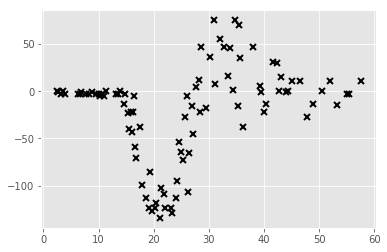

In [127]:
X = data["times"]
Y = data["accel"]
plt.plot(X, Y, 'kx', mew=2)

Construction of a **Gaussian Process Regression** model. 
Other models are:
* GPMC: Gaussian Process Model with MCMC posterior inference on parameters
* SVGP: Stochastic Variational GPs
* ...

In [205]:
k = gpflow.kernels.RBF(1)
m = gpflow.models.GPR(np.matrix(X).T, np.matrix(Y).T, kern=k)
m.kern.variance = 5.
m.kern.variance = 20.
m.likelihood.variance = 10.0
m.compile()

In [206]:
def plot(m, xstart, xend):
        
    xx = np.linspace(xstart, xend, 100)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(xstart, xend)

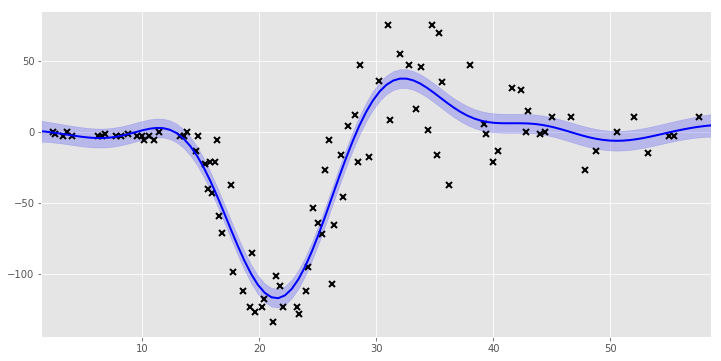

In [207]:
plot(m, np.min(X) - 1, np.max(X) + 1)

A compiled GP can be optimized using ML as follows:
```python
gpflow.train.ScipyOptimizer().minimize(m)
plot(m)
m
```

# Product of Experts

In [256]:
experts = 5

# list of experts
poe = []

# splits (random in this case)
splitsPos = np.random.rand(experts-1) * np.max(X) + np.min(X)
splitsPos = np.sort(splitsPos)

print("Split positions: ", splitsPos)

Split positions:  [  5.79087228  40.09329271  48.16802327  58.50986356]


In [277]:
for (startPos, endPos) in zip(np.hstack([np.min(X) - 1, splitsPos]), np.hstack([splitsPos, np.max(X) + 1])):
    print("Learning Expert for data between: ", startPos, " -> ", endPos)
    
    X_ = X[(X > endPos) & (X >= startPos)]
    Y_ = Y[(X > endPos) & (X >= startPos)]
    
    k = gpflow.kernels.RBF(1)
    m = gpflow.models.GPR(np.matrix(X_).T, np.matrix(Y_).T, kern=k)
    m.kern.variance = 5.
    m.kern.variance = 20.
    m.likelihood.variance = 10.0
    m.compile()
    poe.append(m)

Learning Expert for data between:  1.4  ->  5.79087227689
Learning Expert for data between:  5.79087227689  ->  40.0932927074
Learning Expert for data between:  40.0932927074  ->  48.1680232658
Learning Expert for data between:  48.1680232658  ->  58.5098635621
Learning Expert for data between:  58.5098635621  ->  58.6


In [278]:
def plotPoE(M, xstart, xend):
    xx = np.linspace(xstart, xend, 100)[:,None]
    
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    
    ymean = np.zeros((len(xx), len(M)))
    yvar = np.zeros((len(xx), len(M)))

    for (mi, m) in enumerate(M):
        mean, var = m.predict_y(xx)
        ymean[:,mi] = mean[:,0]
        yvar[:,mi] = var[:,0]
            
    jointVar =  1 / np.sum(1 / yvar, 1)
    jointMean = jointVar * np.sum(np.divide(ymean, yvar), 1)
    
    plt.plot(xx, jointMean, 'b', lw=2)
    plt.fill_between(xx[:,0], jointMean - 2*np.sqrt(jointVar), jointMean + 2*np.sqrt(jointVar), color='blue', alpha=0.2)
    plt.xlim(xstart, xend)

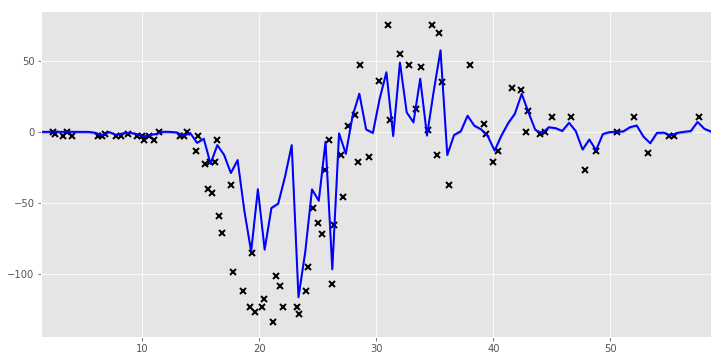

In [279]:
plotPoE(poe, np.min(X) - 1, np.max(X) + 1)